In [4]:
## Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
## Loading the Dataset
df = pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [7]:
#Display first few rows
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [8]:
## Getting Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [9]:
## Checking for missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [10]:
## Checking for duplicate values
df.duplicated().any()

True

In [11]:
df[df[['age','sex','bmi','children','smoker','region','charges']].duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [12]:
## Since there is just one duplicate value we can drop it
df.drop_duplicates(inplace=True)

In [13]:
smoker_charges = df.groupby('smoker')['charges'].mean()
smoker_charges

smoker
no      8440.660307
yes    32050.231832
Name: charges, dtype: float64

Let's check how these features are affecting dependent variable via plotting.

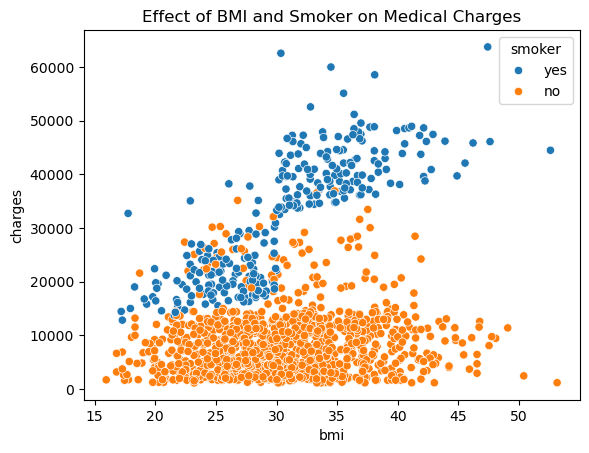

In [15]:
sns.scatterplot(x=df['bmi'], y=df['charges'], hue=df['smoker'])
plt.title("Effect of BMI and Smoker on Medical Charges")
plt.show()

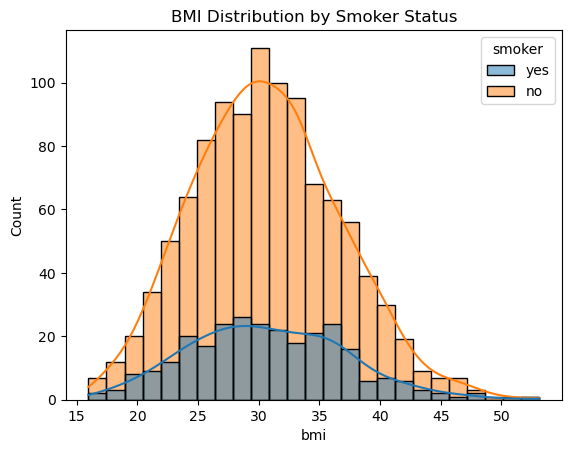

In [16]:
sns.histplot(df, x='bmi', hue='smoker', kde=True)
plt.title("BMI Distribution by Smoker Status")
plt.show()

<Figure size 1000x600 with 0 Axes>

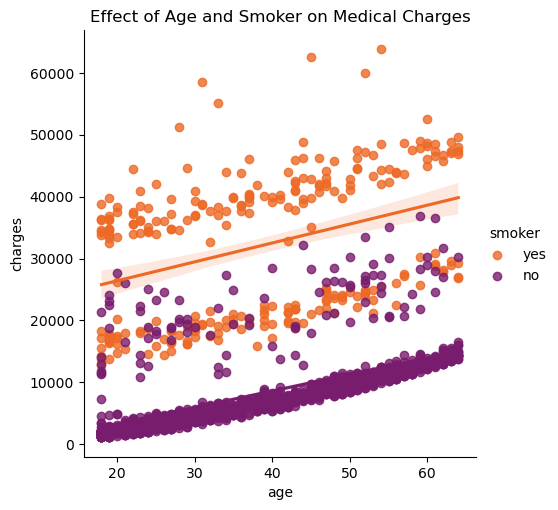

In [17]:
plt.figure(figsize=(10,6))
sns.lmplot(x='age',y='charges', data=df, palette='inferno_r', hue='smoker')
plt.title("Effect of Age and Smoker on Medical Charges")
plt.show()

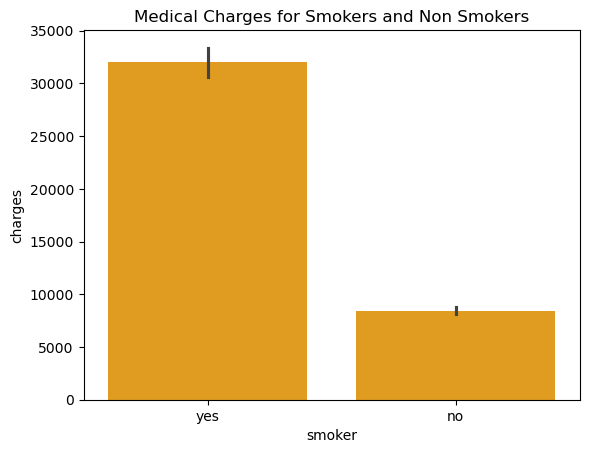

In [18]:
sns.barplot(x=df['smoker'],y=df['charges'], color='orange')
plt.title("Medical Charges for Smokers and Non Smokers")
plt.show()

In [19]:
bmi_smoker = df.groupby('smoker')['bmi'].mean()
bmi_smoker

smoker
no     30.651853
yes    30.708449
Name: bmi, dtype: float64

In [20]:
age_smoker = df.groupby('smoker')['age'].mean()
age_smoker

smoker
no     39.404516
yes    38.514599
Name: age, dtype: float64

###### 
On analyzing the relationship between BMI,smoking status and age, the average BMI of smokers (30.70) and non-smokers (30.65) is almost identical. Same way the average age of smokers(38.51) and non-smokers(39.40) is almost identical. This indicates that BMI and age is not significantly different across smoking groups. 
Since smoking already has a strong impact on charges, creating an interaction term like (BMI × Smoker) or (Age x Smoker) would not add meaningful information to the model. Instead, we will keep ‘Smoker’ as a standalone feature and evaluate the importance of BMI and Age separately.

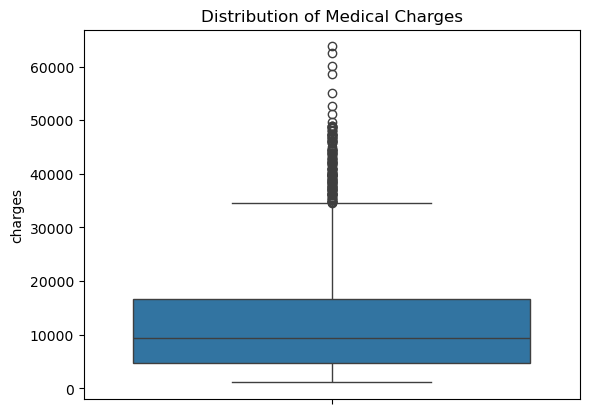

In [22]:
## Checking for outliers
sns.boxplot(df['charges'])
plt.title('Distribution of Medical Charges')
plt.show()

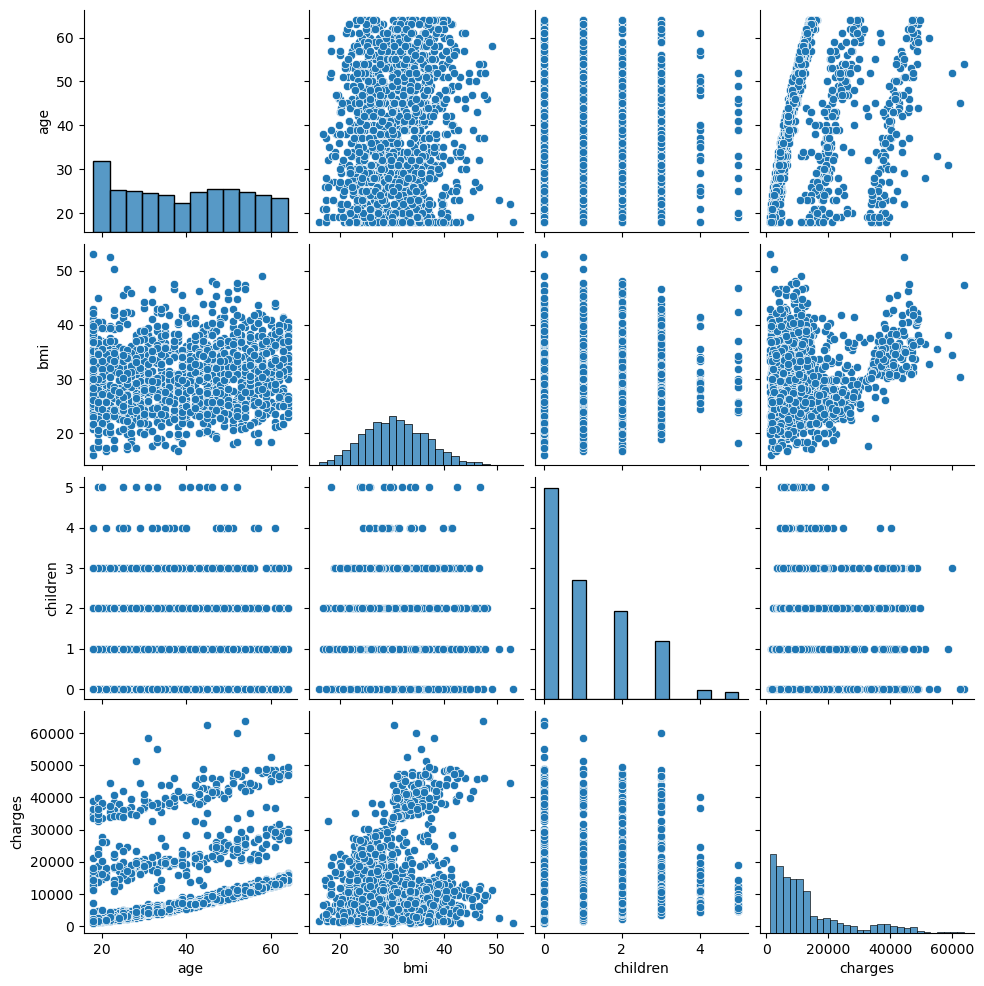

In [23]:
## Checking the relationship of features with each other
sns.pairplot(df)
plt.show()

In [24]:
## checking unique values
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [25]:
cat_features = [feature for feature in df.columns if df[feature].dtype=='O']
print("Categorical Features are:",len(cat_features))
num_features = [feature for feature in df.columns if df[feature].dtype!='O']
print("Numerical Features are:",len(num_features))
discrete_features = [feature for feature in num_features if len(df[feature].unique())<25]
print("Discrete Features are:",len(discrete_features))
continuous_features = [feature for feature in num_features if feature not in discrete_features]
print("Continuous Features are:",len(continuous_features))

Categorical Features are: 3
Numerical Features are: 4
Discrete Features are: 1
Continuous Features are: 3


In [26]:
## Encoding Categorical Features to check correlation
df_encoded = pd.get_dummies(df, columns=cat_features, drop_first=True).astype(int)

In [27]:
df_encoded

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27,0,16884,0,1,0,0,1
1,18,33,1,1725,1,0,0,1,0
2,28,33,3,4449,1,0,0,1,0
3,33,22,0,21984,1,0,1,0,0
4,32,28,0,3866,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30,3,10600,1,0,1,0,0
1334,18,31,0,2205,0,0,0,0,0
1335,18,36,0,1629,0,0,0,1,0
1336,21,25,0,2007,0,0,0,0,1


In [28]:
corr=df_encoded.corr()

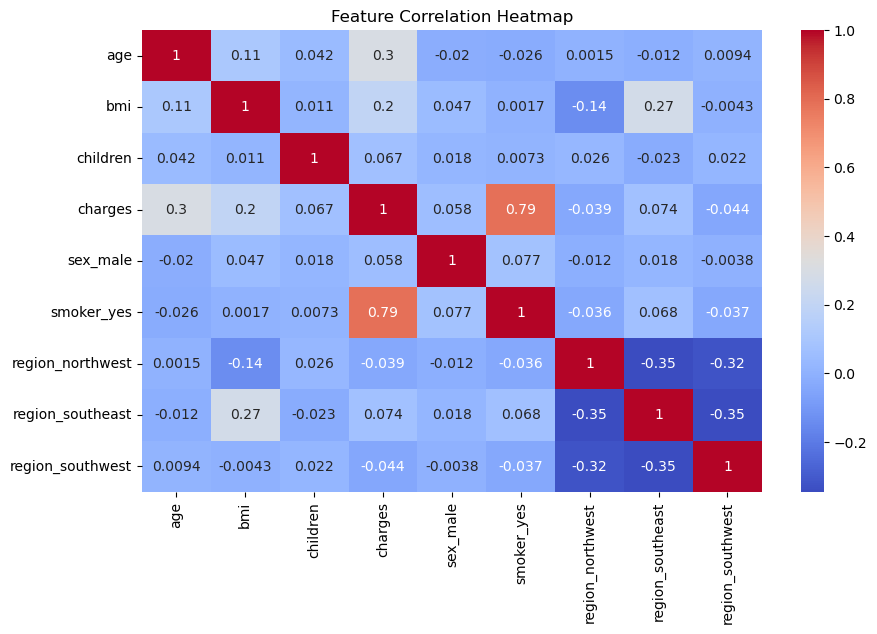

In [29]:
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot = True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [30]:
def correlation(dataset,threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold:
                colname=corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [31]:
corr_features = correlation(df_encoded,0.85)
len(set(corr_features))

0

In [32]:
## Splitting x and y value
x = df_encoded.drop('charges', axis=1)
y=df_encoded['charges']

In [33]:
x.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27,0,0,1,0,0,1
1,18,33,1,1,0,0,1,0
2,28,33,3,1,0,0,1,0
3,33,22,0,1,0,1,0,0
4,32,28,0,1,0,1,0,0


In [34]:
y

0       16884
1        1725
2        4449
3       21984
4        3866
        ...  
1333    10600
1334     2205
1335     1629
1336     2007
1337    29141
Name: charges, Length: 1337, dtype: int32

In [35]:
## Train-Test split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20, random_state=42)

In [36]:
x_train.shape

(1069, 8)

In [37]:
x_test.shape

(268, 8)

In [38]:
## Standardizing the Data
from sklearn.preprocessing import StandardScaler

In [39]:
StandardScaler = StandardScaler()

In [40]:
x_train_scaled = StandardScaler.fit_transform(x_train)

In [41]:
x_test_scaled = StandardScaler.transform(x_test)

In [42]:
x_train_scaled

array([[-1.1576804 , -0.99651264, -0.90790804, ..., -0.57266946,
        -0.60581158, -0.57410974],
       [-1.30061876, -0.83173739,  0.7669042 , ..., -0.57266946,
        -0.60581158, -0.57410974],
       [ 0.91492586,  1.14556565,  0.7669042 , ...,  1.74620801,
        -0.60581158, -0.57410974],
       ...,
       [-1.37208794, -1.32606315, -0.07050192, ..., -0.57266946,
        -0.60581158,  1.74182728],
       [-0.08564268, -0.33741163,  1.60431032, ..., -0.57266946,
        -0.60581158,  1.74182728],
       [-0.30005022,  0.81601515,  0.7669042 , ..., -0.57266946,
         1.65067825, -0.57410974]])

## Model Implementation

In [44]:
## Model Training and Evaluation Function
def evaluate_model(model,x_train,y_train,x_test,y_test):
    model.fit(x_train,y_train)
    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)

    ##Training metrics
    print(f'{model.__class__.__name__} Performance:')
    print("Training Data Performance:")
    print("MAE:",mean_absolute_error(y_train,y_pred_train))
    print("MSE:",mean_squared_error(y_train,y_pred_train))
    print("R2 Score:",r2_score(y_train,y_pred_train))
    print("RMSE:",np.sqrt(mean_squared_error(y_train,y_pred_train)))

    print("-"*20)

    ## Testing metrics
    print("Testing Data Performance:")
    print("MAE:",mean_absolute_error(y_test,y_pred_test))
    print("MSE:",mean_squared_error(y_test,y_pred_test))
    print("R2 Score:",r2_score(y_test,y_pred_test))
    print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred_test)))
    
    print("="*40)
    return y_pred_test

In [45]:
lr = LinearRegression()
y_pred_lr = evaluate_model(lr, x_train_scaled, y_train, x_test_scaled, y_test)

rf = RandomForestRegressor()
y_pred_rf = evaluate_model(rf, x_train_scaled, y_train, x_test_scaled, y_test)

xgb = XGBRegressor()
y_pred_xgb = evaluate_model(xgb, x_train_scaled, y_train, x_test_scaled, y_test)

LinearRegression Performance:
Training Data Performance:
MAE: 4180.669562119708
MSE: 36984867.28114135
R2 Score: 0.7298693010380308
RMSE: 6081.518501257835
--------------------
Testing Data Performance:
MAE: 4171.800293113269
MSE: 35475294.14291125
R2 Score: 0.8069435680345957
RMSE: 5956.114013592356
RandomForestRegressor Performance:
Training Data Performance:
MAE: 1061.9632972292752
MSE: 3518346.6209262647
R2 Score: 0.9743026404643633
RMSE: 1875.7256251718331
--------------------
Testing Data Performance:
MAE: 2718.91920931059
MSE: 22925517.831673972
R2 Score: 0.8752394087075772
RMSE: 4788.059923567579
XGBRegressor Performance:
Training Data Performance:
MAE: 674.6393219079783
MSE: 1399283.5567108262
R2 Score: 0.9897798895835876
RMSE: 1182.9131653299096
--------------------
Testing Data Performance:
MAE: 3117.1950659680724
MSE: 27398060.238222465
R2 Score: 0.8508998155593872
RMSE: 5234.3156418220005


In [46]:
rf_params = {
    'n_estimators':[100,200,300,500,1000],
    'max_depth':[3,5,8,9,10],
    'min_samples_split':[2,3,5,7,8],
    'criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
}
xgb_params = {
    'n_estimators':[100,200,300,500,1000],
    'learning_rate':[0.1,0.01,0.001,0,1.0],
    'max_depth':[3,5,8,9,None],
    'colsample_bytree':[0.3,0.5,0.6,0.8,1.0]
}

In [47]:
from sklearn.model_selection import RandomizedSearchCV
randomcv_models = [
    ('RF',RandomForestRegressor(),rf_params),
    ('XGB',XGBRegressor(),xgb_params)
]

In [48]:
model_params = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,param_distributions=params,cv=3,n_iter=100,verbose=3,n_jobs=-1)
    random.fit(x_train_scaled,y_train)
    model_params[name]=random.best_params_

for model_name in model_params:
    print(f'-----------------Best Params for {model_name}:--------------------')
    print(model_params[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
-----------------Best Params for RF:--------------------
{'n_estimators': 200, 'min_samples_split': 8, 'max_depth': 5, 'criterion': 'friedman_mse'}
-----------------Best Params for XGB:--------------------
{'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


In [49]:
rf = RandomForestRegressor(n_estimators=100, min_samples_split=7, max_depth=5, criterion='squared_error')
y_pred_rf = evaluate_model(rf, x_train_scaled, y_train, x_test_scaled, y_test)

xgb = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, colsample_bytree=0.6)
y_pred_xgb = evaluate_model(xgb, x_train_scaled, y_train, x_test_scaled, y_test)

RandomForestRegressor Performance:
Training Data Performance:
MAE: 2288.7244697033484
MSE: 17071579.484851334
R2 Score: 0.8753123091243552
RMSE: 4131.77679513927
--------------------
Testing Data Performance:
MAE: 2463.097436231272
MSE: 18219471.31534473
R2 Score: 0.9008496980950519
RMSE: 4268.4272648535
XGBRegressor Performance:
Training Data Performance:
MAE: 2332.7140001059693
MSE: 17462001.53634783
R2 Score: 0.8724607229232788
RMSE: 4178.75597951685
--------------------
Testing Data Performance:
MAE: 2677.406307391266
MSE: 19712369.904620014
R2 Score: 0.8927253484725952
RMSE: 4439.861473584509


In [50]:
rf.feature_importances_

array([1.27072439e-01, 1.72392532e-01, 1.51591526e-02, 5.84803585e-04,
       6.81558813e-01, 1.48613513e-03, 9.91089516e-04, 7.55035603e-04])

In [51]:
xgb.feature_importances_

array([0.03776781, 0.05020581, 0.00799051, 0.00398085, 0.8839639 ,
       0.00558867, 0.00479027, 0.00571219], dtype=float32)

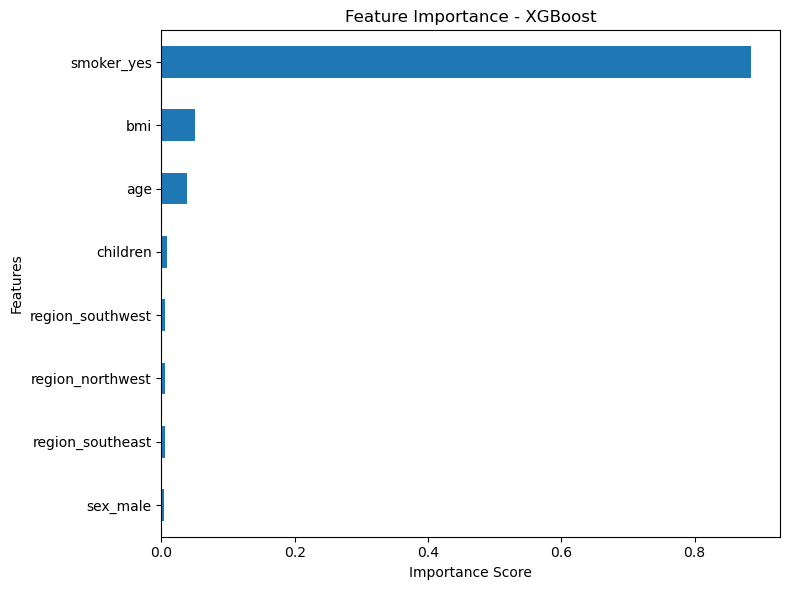

In [52]:
xgb_importance = pd.Series(xgb.feature_importances_, index=x.columns)
xgb_importance.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

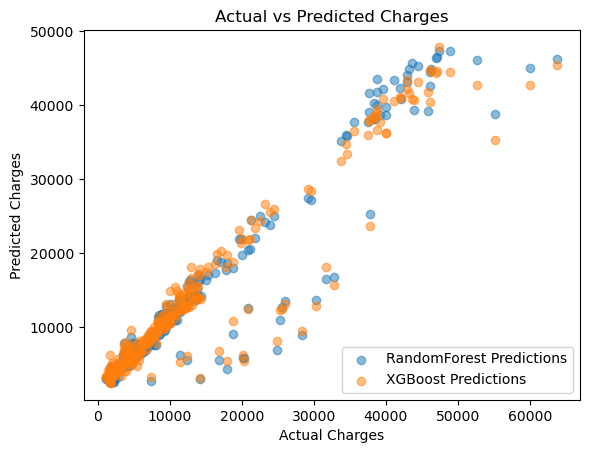

In [53]:
## Comparing actual vs predicted
plt.scatter(y_test,y_pred_rf, alpha=0.5, label='RandomForest Predictions')
plt.scatter(y_test,y_pred_xgb,alpha=0.5, label="XGBoost Predictions")
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.legend(loc="lower right")
plt.title("Actual vs Predicted Charges")
plt.show()

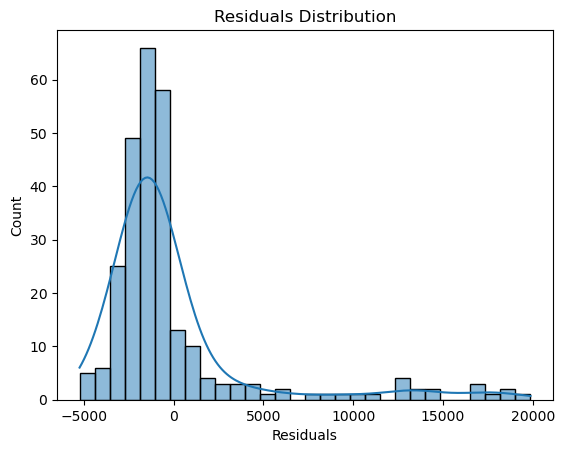

In [54]:
## Residual Plot for xgboost
residuals = y_test - y_pred_xgb
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Residuals Distribution")
plt.show()

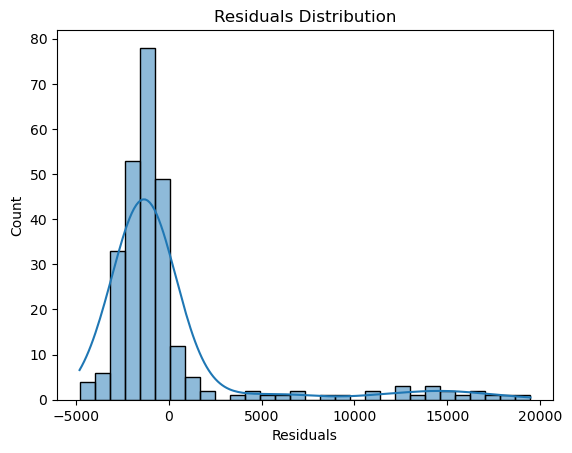

In [55]:
## Residual Plot for randomforest
residuals = y_test - y_pred_rf
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Residuals Distribution")
plt.show()

# Conclusion

In this analysis, I explored the key factors influencing medical insurance costs and developed predictive models to estimate charges based on patient attributes.

### Feature Insights:

Smokers tend to have significantly higher medical insurance costs.

BMI and Age show a clear impact on charges, though BMI categories did not strongly justify interaction features.

Region and Sex have minimal impact on cost predictions.

### Model Performance:

Linear Regression showed reasonable predictive power but was slightly underfitting.

Random Forest Regressor performed well with an R² of 0.90 on test data and low error values, indicating strong predictive ability.

XGBoost Regressor, while slightly less accurate than Random Forest on test data, also performed well with an R² of 0.89.

### Final Model Selection:

RandomForestRegressor and XGBoost appears to be the best-performing model with the highest generalization ability.